
Import Libraries and Define Initial Parameters



In [11]:
# Cell to Import Libraries and Define Initial Parameters
!pip install gym # a toolkit for developing and comparing reinforcement learning algorithms.
!pip install stable-baselines3[extra] # collection of popular reinforcement learning algorithms.
!pip install 'shimmy>=2.0'

!pip install scikit-learn # used for machine learning tasks such as data preprocessing, modeling, and evaluation.

Data Generation and Preprocessing

In [12]:
# Cell for Data Generation and Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler # For standardizing features to have a mean of 0 and variance of 1
from imblearn.over_sampling import SMOTE # For handling imbalanced datasets using Synthetic Minority Over-sampling Technique
from collections import Counter # For counting occurrences of class labels

# Seed for reproducibility
np.random.seed(0)

# Generate synthetic data
num_data = 1000 # Number of data points to generate
data = {
    'temperature': np.random.normal(50, 10, num_data),
    'vibration': np.random.normal(0.5, 0.1, num_data),
    'operational_hours': np.random.normal(10, 2, num_data),
    'failure': np.random.binomial(1, 0.1, num_data) # Binary failure status with a 10% probability of failure
}
df = pd.DataFrame(data)

# Add new features to track changes in temperature and vibration
df['temp_change'] = df['temperature'].diff().fillna(0)
df['vib_change'] = df['vibration'].diff().fillna(0)


# Feature scaling and data splitting
features = df[['temperature', 'vibration', 'operational_hours', 'temp_change', 'vib_change']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['failure'], test_size=0.2, random_state=0)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

Original class distribution: Counter({0: 737, 1: 63})
Resampled class distribution: Counter({0: 737, 1: 737})


Define the EquipementEnv Class

In [13]:
import gym  # Import the gym module
from gym import spaces  # Import spaces from gym
import numpy as np

class EquipmentEnv(gym.Env):
    """Custom Environment that follows gym interface."""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, labels):
        super(EquipmentEnv, self).__init__()
        self.data = data  # Assuming data is a DataFrame, convert to numpy for consistent indexing
        self.labels = labels.values  # Convert labels to numpy array to avoid indexing issues
        self.index = 0
        self.action_space = spaces.Discrete(2)  # Binary actions: 0 (no maintenance) or 1 (maintenance)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1],), dtype=np.float32
        )

    def step(self, action):
        """Perform a step in the environment."""
        self.index += 1  # Move to the next index
        done = self.index >= len(self.data)  # Check if we reached the end of the data

        # Initialize the reward
        reward = 0

        # Only calculate rewards if the episode is not done
        if not done:
            if action == 1 and self.labels[self.index] == 1:
                reward = 50  # Reward for correct maintenance
            elif action == 0 and self.labels[self.index] == 0:
                reward = 5  # Reward for correctly avoiding maintenance
            elif action == 1 and self.labels[self.index] == 0:
                reward = -1  # Penalty for unnecessary maintenance
            elif action == 0 and self.labels[self.index] == 1:
                reward = -12  # Penalty for missing required maintenance

            # Print to track rewards and actions
            print(f"Step {self.index}: Action={action}, Label={self.labels[self.index]}, Reward={reward}")

        # Prepare the next state or a zeroed state if the episode is done
        next_state = (
            self.data[self.index] if not done else np.zeros(self.observation_space.shape)
        )

        # Return the step information
        info = {}
        return next_state, reward, done, info

    def reset(self):
        """Reset the environment to the initial state."""
        self.index = np.random.randint(0, len(self.data) - 1)  # Randomize the initial state
        print(f"Environment reset. Starting index: {self.index}")
        return self.data[self.index]

    def render(self, mode='human', close=False):
        """Render the current state of the environment."""
        if mode == 'human':
            print(f"Current Index: {self.index}")
        pass


Training

In [14]:
from stable_baselines3 import PPO

# Create the training environment
env = EquipmentEnv(X_train, y_train)

# Define the PPO model
model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.01)  # Entropy for exploration

# Train the model
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Step 641: Action=1, Label=1, Reward=50
Step 642: Action=0, Label=0, Reward=5
Step 643: Action=0, Label=0, Reward=5
Step 644: Action=0, Label=0, Reward=5
Step 645: Action=0, Label=0, Reward=5
Step 646: Action=0, Label=0, Reward=5
Step 647: Action=1, Label=0, Reward=-1
Step 648: Action=0, Label=0, Reward=5
Step 649: Action=1, Label=0, Reward=-1
Step 650: Action=1, Label=0, Reward=-1
Step 651: Action=0, Label=0, Reward=5
Step 652: Action=1, Label=0, Reward=-1
Step 653: Action=1, Label=0, Reward=-1
Step 654: Action=1, Label=0, Reward=-1
Step 655: Action=1, Label=0, Reward=-1
Step 656: Action=1, Label=0, Reward=-1
Step 657: Action=0, Label=0, Reward=5
Step 658: Action=0, Label=0, Reward=5
Step 659: Action=1, Label=0, Reward=-1
Step 660: Action=0, Label=0, Reward=5
Step 661: Action=0, Label=0, Reward=5
Step 662: Action=0, Label=0, Reward=5
Step 663: Action=0, Label=0, Reward=5
Step 664: Action=1, Label=1, Reward=50
Step 665: Action=0, Label=

Evaluation

In [15]:
# Create the evaluation environment
eval_env = EquipmentEnv(X_test, y_test)

# Reset the environment
obs = eval_env.reset()
done = False

# Evaluate the model
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    print(f"Action: {action}, Reward: {reward}")
    if done:
        obs = eval_env.reset()  # Properly reset the environment at the end of an episode


Environment reset. Starting index: 12
Step 13: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 14: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 15: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 16: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 17: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 18: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 19: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 20: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 21: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 22: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 23: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 24: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 25: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 26: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 27: Action=0, Label=0, Reward=5
Action: 0, Reward: 5
Step 28: Action=1, Label=0, Reward=-1
Action: 1, Reward: -1
Step 29: Actio

Streaming output truncated to the last 5000 lines.
Episode: 6, Action: 1, Reward: -1
Step 417: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 418: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 419: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 420: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 421: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 422: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 423: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 424: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 425: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 426: Action=1, Label=0, Reward=-1
Episode: 6, Action: 1, Reward: -1
Step 427: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 428: Action=0, Label=0, Reward=5
Episode: 6, Action: 0, Reward: 5
Step 429: Action=1, Label=0, Reward=-1
Episode: 6, 

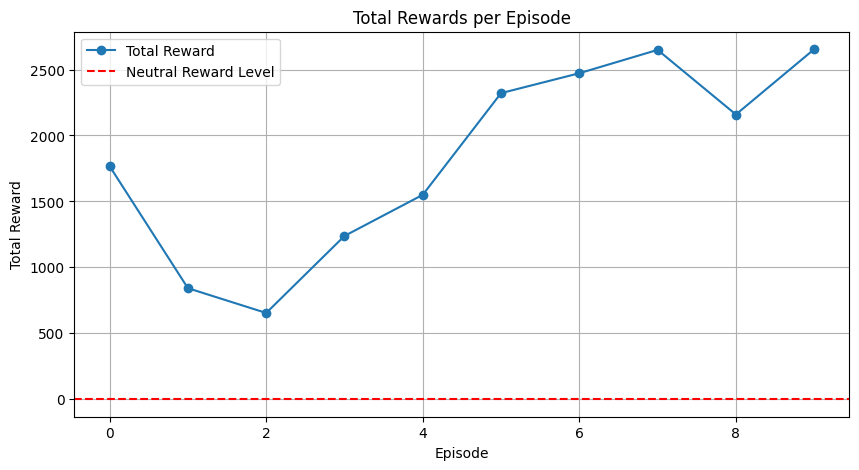

In [16]:
import logging
import sys
import matplotlib.pyplot as plt

# Configure logging to print to console only
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)  # Print to console only
    ]
)

# Store total rewards for visualization
rewards = []

# Training and logging
for episode in range(10):  # Example: Running 10 evaluation episodes
    print(f"Starting episode {episode}")
    logging.info(f"Starting episode {episode}")  # Log start of episode
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _states = model.predict(state, deterministic=True)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        logging.info(f'Episode: {episode}, Action: {action}, Reward: {reward}')
        print(f'Episode: {episode}, Action: {action}, Reward: {reward}')  # Debug print
    logging.info(f'Total reward for episode {episode}: {total_reward}')
    print(f'Total reward for episode {episode}: {total_reward}')  # Debug print
    rewards.append(total_reward)  # Collect total rewards in the list

# Debug: Check collected rewards
print("Collected rewards:", rewards)

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(range(len(rewards)), rewards, marker='o', linestyle='-', label="Total Reward")
plt.axhline(y=0, color='r', linestyle='--', label="Neutral Reward Level")  # Neutral reward line
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


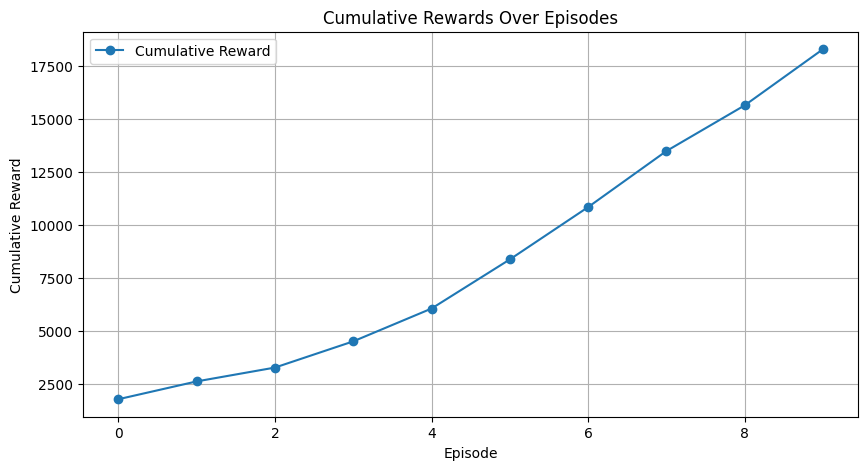

In [17]:
cumulative_rewards = [sum(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_rewards)), cumulative_rewards, marker='o', linestyle='-', label="Cumulative Reward")
plt.title('Cumulative Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()


Environment reset. Starting index: 177
Step 178: Action=0, Label=1, Reward=-12
Step 179: Action=1, Label=0, Reward=-1
Step 180: Action=0, Label=0, Reward=5
Step 181: Action=0, Label=0, Reward=5
Step 182: Action=1, Label=0, Reward=-1
Step 183: Action=0, Label=0, Reward=5
Step 184: Action=0, Label=0, Reward=5
Step 185: Action=0, Label=0, Reward=5
Step 186: Action=0, Label=0, Reward=5
Step 187: Action=1, Label=0, Reward=-1
Step 188: Action=1, Label=0, Reward=-1
Step 189: Action=0, Label=0, Reward=5
Step 190: Action=1, Label=0, Reward=-1
Step 191: Action=1, Label=0, Reward=-1
Step 192: Action=0, Label=0, Reward=5
Step 193: Action=0, Label=0, Reward=5
Step 194: Action=0, Label=0, Reward=5
Step 195: Action=0, Label=0, Reward=5
Step 196: Action=0, Label=0, Reward=5
Step 197: Action=0, Label=0, Reward=5
Step 198: Action=0, Label=0, Reward=5
Step 199: Action=0, Label=0, Reward=5
Environment reset. Starting index: 147
Step 148: Action=1, Label=0, Reward=-1
Step 149: Action=0, Label=0, Reward=5
S

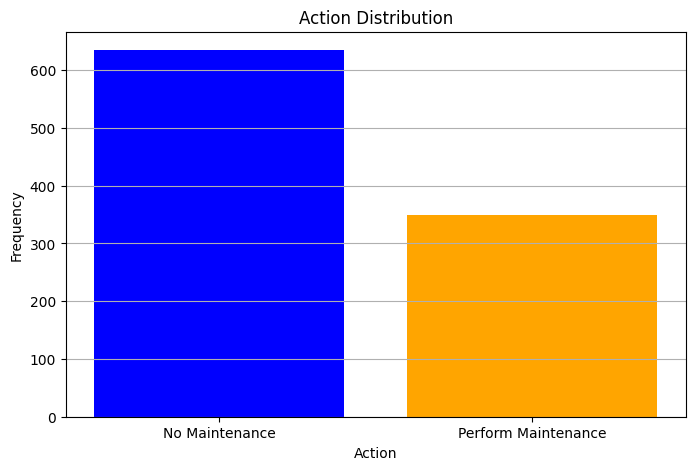

In [18]:
action_distribution = {0: 0, 1: 0}

for episode in range(10):  #
    obs = eval_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_distribution[int(action)] += 1
        obs, reward, done, _ = eval_env.step(action)

actions = list(action_distribution.keys())
frequencies = list(action_distribution.values())

plt.figure(figsize=(8, 5))
plt.bar(actions, frequencies, color=["blue", "orange"])
plt.title("Action Distribution")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["No Maintenance", "Perform Maintenance"])
plt.grid(axis='y')
plt.show()
